In [7]:
import io
import os
import torch
import random
import pandas as pd
import numpy as np
import scipy as sp
import pickle
import glob

from collections import Counter

import sklearn.metrics as skm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt


import plotly.graph_objects as go
import plotly.express as px
from plotnine import *
import patchworklib as pw

<Figure size 72x72 with 0 Axes>

In [13]:
# uncomment to load pickle files from GPU to CPU

'''
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)
'''

"\nclass CPU_Unpickler(pickle.Unpickler):\n    def find_class(self, module, name):\n        if module == 'torch.storage' and name == '_load_from_bytes':\n            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')\n        else:\n            return super().find_class(module, name)\n"

In [92]:
FILES_PATH="./Figure2_data/"
files=os.listdir(FILES_PATH)

### 2a.

In [51]:
def get_performance_scores(file_name="", data_name="MSSM"):
    
    f1_df={}
    bacc_df={}
    
    file=open(file_name,"rb")
    f=pickle.load(file)
    sample_ids=f["samples"]

    results=pd.DataFrame({"te_true":f["te_truth"], "te_pred":f["te_pred_scores"]}, index=f['samples'])
    new_true=results["te_true"].to_list()
    new_pred=results["te_pred"].to_list()
    new_pred_labels=results["te_pred"].to_list()
    new_pred_labels=[1 if x>=0.5 else 0 for x in new_pred]

    # AUPRC
    lr_precision, lr_recall, _ = skm.precision_recall_curve(new_true, new_pred)
    pr_auc = skm.auc(lr_recall, lr_precision)
    pr_auc = round(pr_auc,3)

    # BACC
    bacc=(round(skm.balanced_accuracy_score(y_pred=new_pred_labels, y_true=new_true),3))
    bacc_df[f"{data_name}"] = bacc

    # F-1 score
    f1_s=round(skm.f1_score(new_true, new_pred_labels),3)
    f1_df[f"{data_name}"] = f1_s

    # confusion matrix
    # cm=confusion_matrix(new_true, new_pred_labels)
    # print (cm)

    # AUROC
    fpr, tpr, thresholds = skm.roc_curve(new_true, new_pred)
    auc = round(skm.auc(fpr, tpr),3)

    prc_df = pd.DataFrame({"precision":lr_precision, "recall":lr_recall,"score":[f"{data_name}:\nauc={pr_auc}\n"]*len(lr_recall)})
    roc_df = pd.DataFrame({"True Positive Rate":tpr, "False Positive Rate":fpr,"score":[f"{data_name}:\nauc={auc}\n"]*len(tpr)})

    return roc_df, prc_df, f1_df, bacc_df

def auc_curves(df,x="False Positive Rate",y="True Positive Rate",fill="score",save=None,save_path=""):
    p=(
        ggplot(df, aes(x=f'{x}', y=f'{y}',color=f'{fill}',))
        + geom_line(aes(linetype=f'{fill}'),size=0.5) # line plot
        + scale_color_manual(values=['black','grey'])
        + scale_linetype_manual(values=['solid','dashed'])
        + labs(x=f'{x}', y=f'{y}')
        +theme_minimal()
        + theme(
            panel_border=element_rect(colour = "black", size=0.5),
            panel_grid_major=element_blank(),#element_line(colour="#d3d3d3"),
            panel_grid_minor=element_blank(),
            panel_background=element_blank(),
            plot_title=element_text(size=15,face="bold"),
            axis_ticks=element_line(colour = "black"),
            text=element_text(size=10),
            axis_text_x=element_text(colour="black", size=10, angle=0),
            axis_text_y=element_text(colour="black", size=10,),
            #aspect_ratio=1.2/4,
            figure_size=(2.5, 2.5),
            legend_position=(0.6,0.3),
            legend_title=element_blank(),
            legend_direction="vertical",
            legend_background = element_blank(),
            legend_box_background = element_rect(colour = "black")
            )
        )
    if save and save_path=="":
        print ("save path must be specified")
    elif save and save_path!="":
        p.save(f'{save_path}', dpi=300)
    
    print (p)
    return p


def bar_plot(df,x="variable",y="value",ylabel="BACC",save=False,save_path=""): 
    
    p=(
        ggplot(df)
        + geom_bar(aes(x=f"{x}", y=f"{y}",fill=f"{x}"), stat='identity')
         + labs(x='', y=f'{ylabel}')
    +theme_minimal()
        + theme(
            panel_border=element_rect(colour = "black", size=0.5),
            panel_grid_major=element_blank(),#element_line(colour="#d3d3d3"),
            panel_grid_minor=element_blank(),
            panel_background=element_blank(),
            plot_title=element_text(size=15,  
                                    face="bold"),
            axis_ticks_major_x=element_blank(),
            text=element_text(size=10),
            axis_text_x=element_blank(),
            axis_text_y=element_text(colour="black", size=10,),
    #         aspect_ratio=1,
            figure_size=(3.5, 3.5),

            legend_title=element_blank(),
            legend_direction="vertical",
            legend_background = element_blank(),
            legend_box_background = element_rect(colour = "black")
        )
#         + scale_fill_manual({"MSSM Heldout":'black',"RUSH+SEA-AD":'grey'})
    )
    
    if save and save_path=="":
        print ("save path must be specified")
    elif save and save_path!="":
        p.save(f'{save_path}', dpi=300)
    
    print (p)
    return p

In [45]:
roc,bacc=pd.DataFrame(),{}

for file in files:
    if "2a" in file:
        name = file.split("_")[1]
        roc_df, _, _, bacc_df = get_performance_scores(file_name=FILES_PATH+file, data_name=name)
        roc = pd.concat([roc,roc_df])
        bacc.update(bacc_df)
        
bacc=pd.DataFrame(bacc, index=["bacc"]).melt()

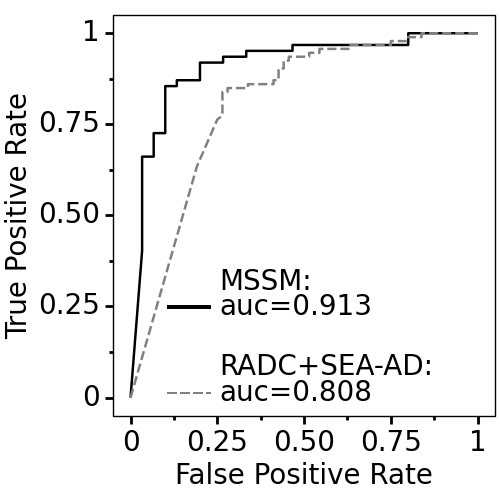

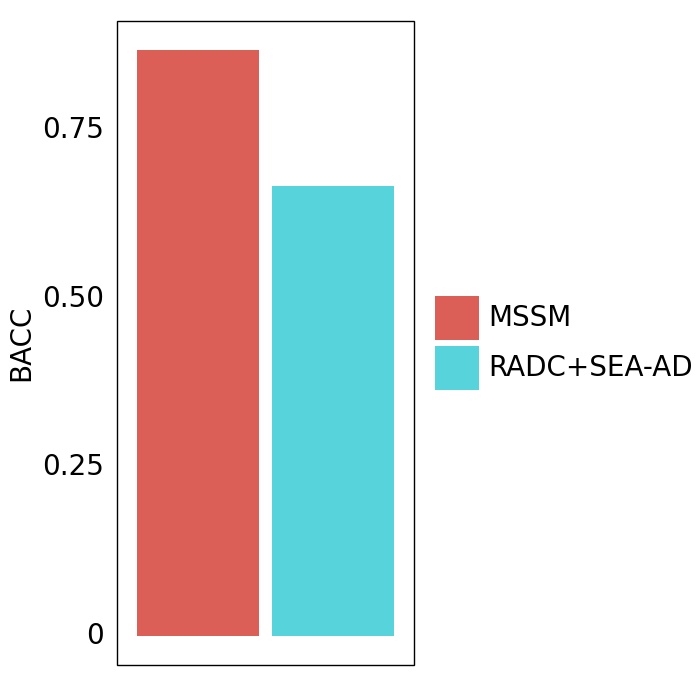

In [52]:
roc_p = auc_curves(roc,x="False Positive Rate",y="True Positive Rate",fill="score")
bacc_p = bar_plot(bacc,ylabel="BACC")

### 2b.

In [60]:
fname = [file for file in files if "2b" in file][0]
nps=pd.read_csv(FILES_PATH+fname,delimiter="\t")
nps.rename(columns={"Train_fold4_AUC.1":"Val_fold4_AUC"}, inplace=True)

c=list(nps["Contrast"].unique())
c={'c07x':"SCZ",
 'c12x':"AD-DLBD",
 'c28x':"AD\nResilience",
 'c71x':"Dys-\nphoria",
 'c72x':"DecInt",
 'c90x':"S/WG\n/G/S",
 'c92x':"D/M",
 'c101x':"Depression: Dysphoria vs Control (L)",
 'c102x':"Depression: DecInt vs Control (L)",
 'c119x':"Depression: Life vs Control (L)",
 'c120x':"Sleep/WeightGain/Guilt/Suicide vs Control (L)",
 'c122x': "Depression/Mood vs Control (L)",
 'r01x': "BRAAK",
 'r03x': "CERAD",
 'r05x': "Cogdx"
  }
st={'c07x':"Disease vs Control",
 'c12x':"Disease vs Control",
 'c28x':"Disease vs Control",
 'c71x':"Neuropsychiatric Symptoms",
 'c72x':"Neuropsychiatric Symptoms",
 'c90x':"Neuropsychiatric Symptoms",
 'c92x':"Neuropsychiatric Symptoms",
 'c101x':"Neuropsychiatric Symptoms",
 'c102x':"Neuropsychiatric Symptoms",
 'c119x':"Neuropsychiatric Symptoms",
 'c120x':"Neuropsychiatric Symptoms",
 'c122x': "Neuropsychiatric Symptoms",
 'r01x': "Disease Progression",
 'r03x': "Disease Progression",
 'r05x': "Disease Progression"
  }

l={'c07x':"A",
 'c12x':"A",
 'c28x':"A",
 'c71x':"Neuropsychiatric Symptoms",
 'c72x':"Neuropsychiatric Symptoms",
 'c90x':"Neuropsychiatric Symptoms",
 'c92x':"Neuropsychiatric Symptoms",
 'c101x':"Neuropsychiatric Symptoms",
 'c102x':"Neuropsychiatric Symptoms",
 'c119x':"Neuropsychiatric Symptoms",
 'c120x':"Neuropsychiatric Symptoms",
 'c122x': "Neuropsychiatric Symptoms",
 'r01x': "B",
 'r03x': "B",
 'r05x': "B"}

In [63]:
metric="F1"

def plot_multi_bar(metric="F1",save=False,save_path=""):

    perf=[]
    contrast=[]
    contrast_name=[]
    stage=[]
    level=[]
    model=[]
    contrasts_to_skip=['c101x','c102x','c119x','c120x','c122x']
    val_auc_cols=[f'Val_fold1_{metric}',f'Val_fold2_{metric}', f'Val_fold3_{metric}', 
                  f'Val_fold4_{metric}', f'Val_fold5_{metric}']

    for n,g in nps.groupby("Contrast"):
        if n in contrasts_to_skip:
            continue
        g=g.sort_values(by=[f"Heldout_{metric}"], ascending=False)
        perf.extend(g.iloc[0].loc[val_auc_cols].values)
        contrast.extend([n]*len(val_auc_cols))
        contrast_name.extend([c[n]]*len(val_auc_cols))
        stage.extend([st[n]]*len(val_auc_cols))
        level.extend([l[n]]*len(val_auc_cols))
        model.extend([g.iloc[0].loc["Model"]]*len(val_auc_cols))

    df=pd.DataFrame()
    df["contrast_name"] = contrast_name
    df["contrast"] = contrast
    df[f"{metric}"] = perf
    df["stage"] = stage
    df["level"] = level
    df["model"] = model

    df=df.sort_values(by=["level","stage"], ascending=True)

    df["stage_cat"] = pd.Categorical(df['stage'], categories=df['stage'].unique())
    df["contrast_name_cat"] = pd.Categorical(df['contrast_name'], categories=df['contrast_name'].unique())

    p = (
        ggplot(df, aes("contrast_name_cat",f"{metric}"))
        + geom_boxplot( fatten=1, width=0.5, )
        + xlab("")
        + ylab(f"      5-Fold\nCross-Validation\n      {metric}")
        + theme_bw()
        + theme(
            panel_grid_major=element_blank(),#element_line(colour="#d3d3d3"),
            panel_grid_minor=element_blank(),
            panel_border=element_rect(colour = "grey", fill=None, size=0.5),
            panel_background=element_blank(),
            plot_title=element_text(size=15,face="bold"),
            text=element_text(size=15),
            axis_text_x=element_text(colour="black", size=15, angle=0),
            axis_text_y=element_text(colour="black", size=15, vjust = 0.1),
            #aspect_ratio=1.2/4
            legend_text=element_text(colour="black", size=15,),
            figure_size=(12,3),
            legend_position="none"
        )
        + guides(fill=guide_legend(ncol=1,title=""))
        + facet_wrap("~stage_cat", scales="free",nrow=1,ncol=3)
        ) 
    print (p)
    
    if save and save_path=="":
        print ("save path must be specified")
    elif save and save_path!="":
        p.save(f'{save_path}', dpi=300)

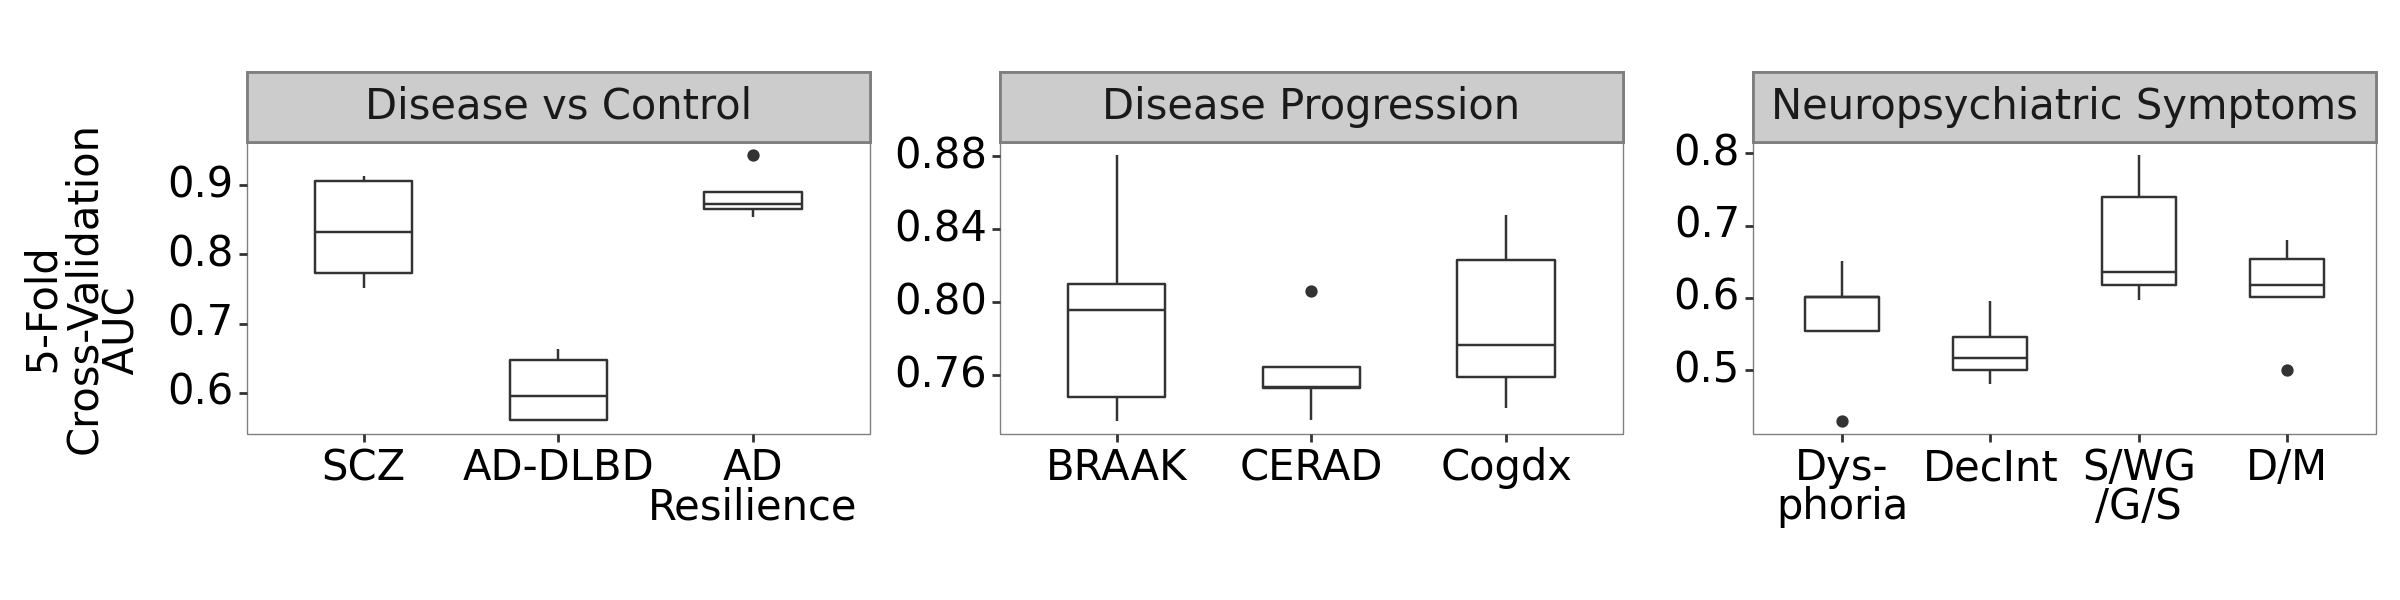

In [67]:
plot_multi_bar(metric="AUC") #metric options: ROC,F1,BACC

### 2c.

In [68]:
import anndata as ad

In [70]:
fname=[file for file in files if "2c" in file][0]

adata=ad.read_h5ad(FILES_PATH+fname)
sample_ids=adata.obs["SubID"].to_list()
adata

In [87]:
def plot_umap(df,x="UMAP1",y="UMAP2", fill="class",color="class",color_dict=None,save=False,save_path=""):
    
    p = (ggplot(aes(x=f'{x}', y=f'{y}'), df)
     + geom_point(aes(color=f"{color}", fill=f"{fill}"), size=4, alpha=0.8)
     + theme_minimal()
     + theme(
             panel_grid_major=element_blank(),
             panel_grid_minor=element_blank(),
             axis_ticks=element_blank(),
             axis_text_x=element_blank(),
             axis_text_y=element_blank(),
             legend_text=element_text(size=25),
             legend_title=element_blank(),
         legend_position=(0.5,0.15),
     )
     +xlab("") + ylab("")
     + scale_color_manual(values=color_dict)
     + scale_fill_manual(values=color_dict)
    )
    
    print (p)
    if save and save_path=="":
        print ("save path must be specified")
    elif save and save_path!="":
        p.save(f'{save_path}', dpi=300)

In [88]:
df1=pd.DataFrame({"UMAP1":adata.obsm["X_umap"][:,0],"UMAP2":adata.obsm["X_umap"][:,1],
                  "class":list(adata.obs["AD"])})
df2=pd.DataFrame({"UMAP1":adata.obsm["X_umap"][:,0],"UMAP2":adata.obsm["X_umap"][:,1],
                  "class_lou":[i for i in list(adata.obs["louvain_str"])],})

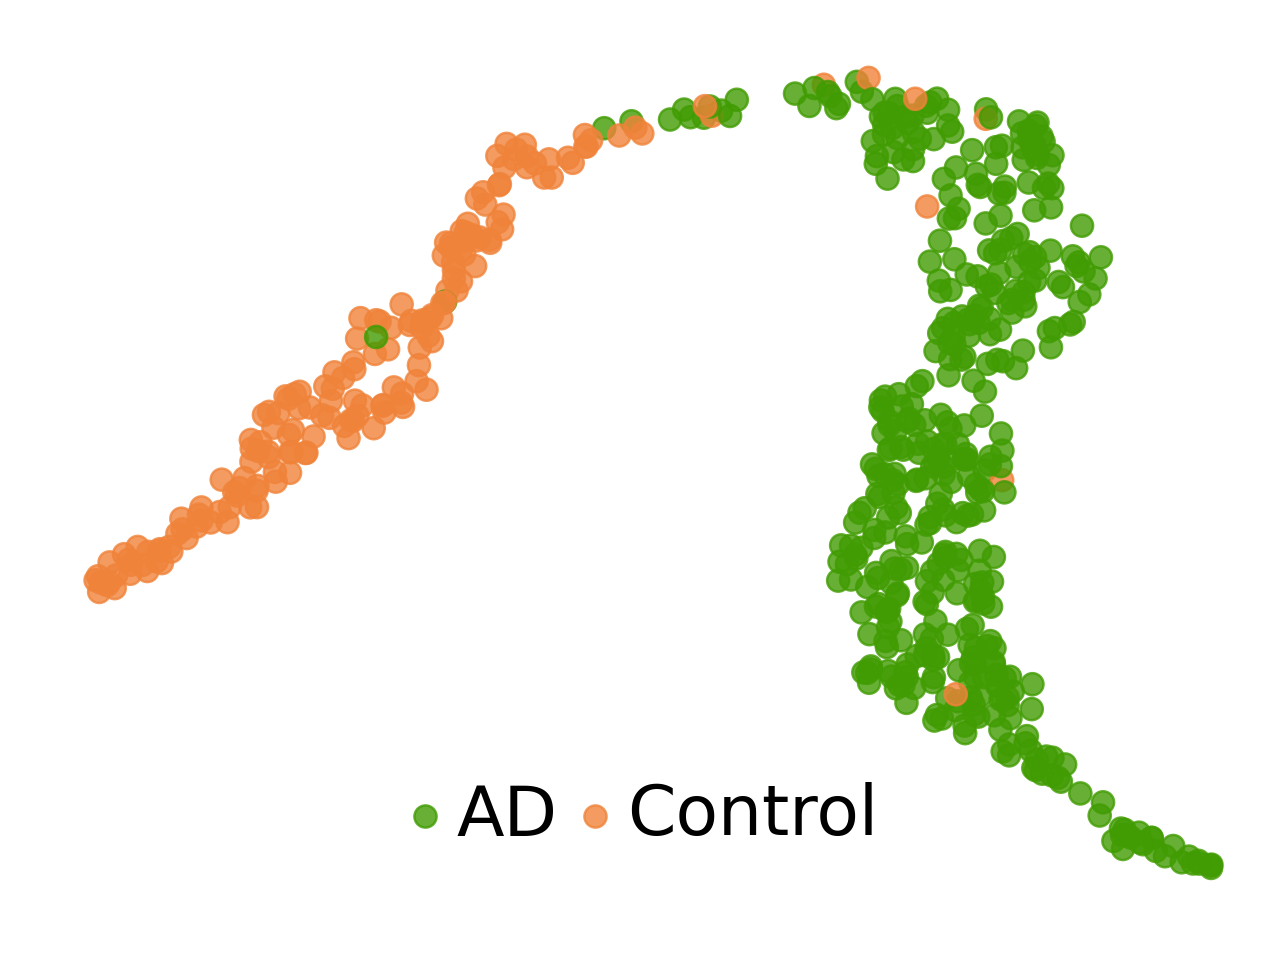

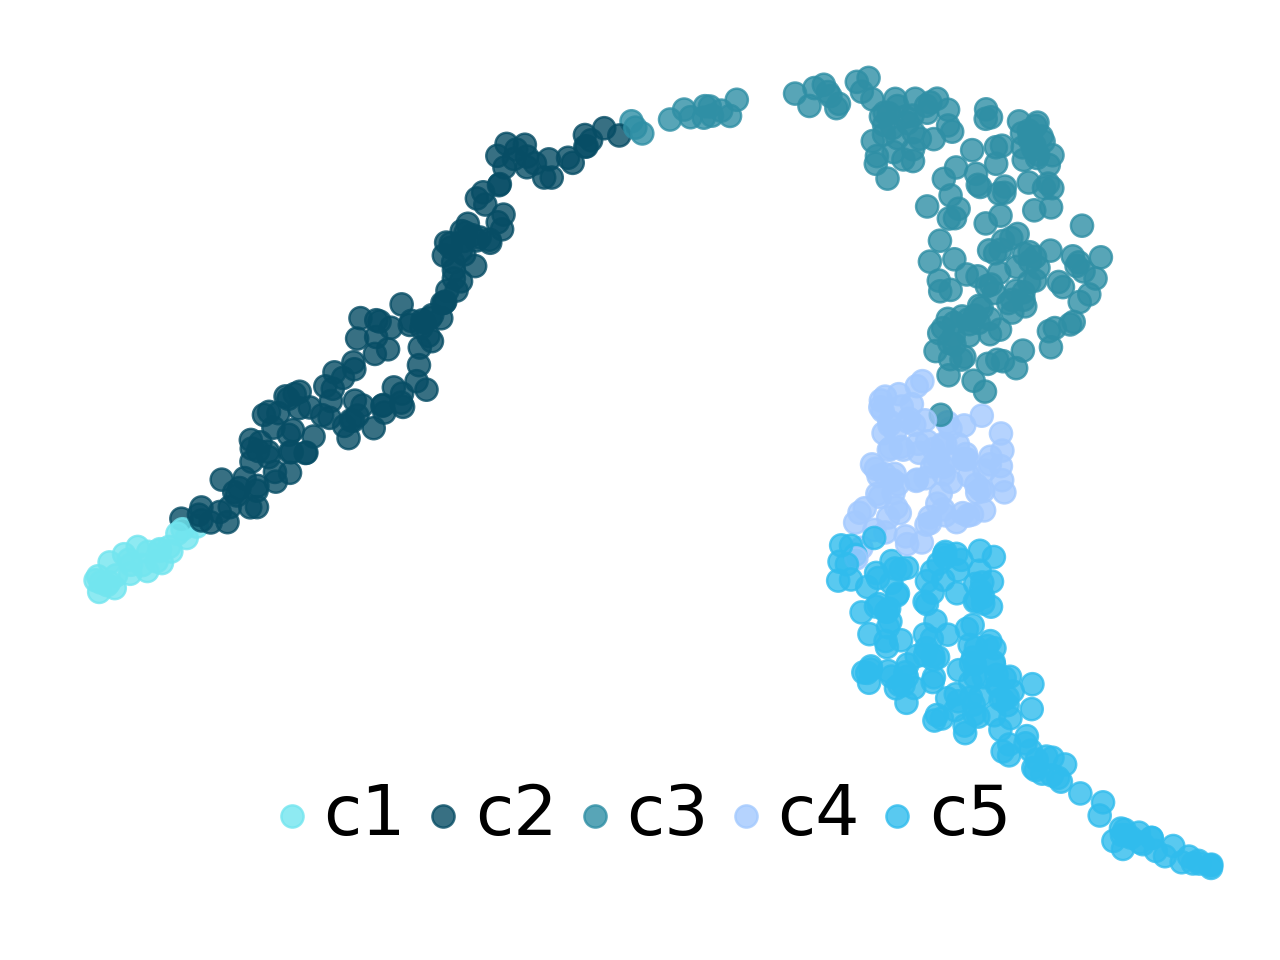

In [91]:
plot_umap(df1,fill="class",color="class",color_dict={ "Control": "#f0833a", "AD": "#419c03" })
plot_umap(df2,fill="class_lou",color="class_lou",color_dict={ "c2": "#074d65","c1": "#72e5ef","c6":"#F45B69", "c4": "#a3c9fe",
                                 "c3": "#2f8fa5", "c5":"#30BCED",})

### 2d.

In [99]:
import seaborn as sns
import matplotlib.gridspec as gridspec

In [97]:
fname = [file for file in files if "2d" in file][0]

In [98]:
enrich_df=pd.read_csv(FILES_PATH+fname, index_col=0)
enrich_df.head()

,c1,c2,c3,c4,c5,c6,c7
20-60,2.929889,9.000000,2.797619e-07,0.000003,1.262395e-09,Age,20-60
60-80,1.225466,3.868508,3.472750e-02,0.540211,2.596467e-05,Age,60-80
>80,0.000003,-0.000000,4.224353e+00,1.071566,1.043951e+01,Age,>80
ApoE4_1,0.006217,0.023700,1.108456e-01,0.990150,1.191140e+00,ApoE,ApoE4_1
ApoE4_0,1.807179,2.432396,1.873700e-01,0.001552,4.289524e-02,ApoE,ApoE4_0


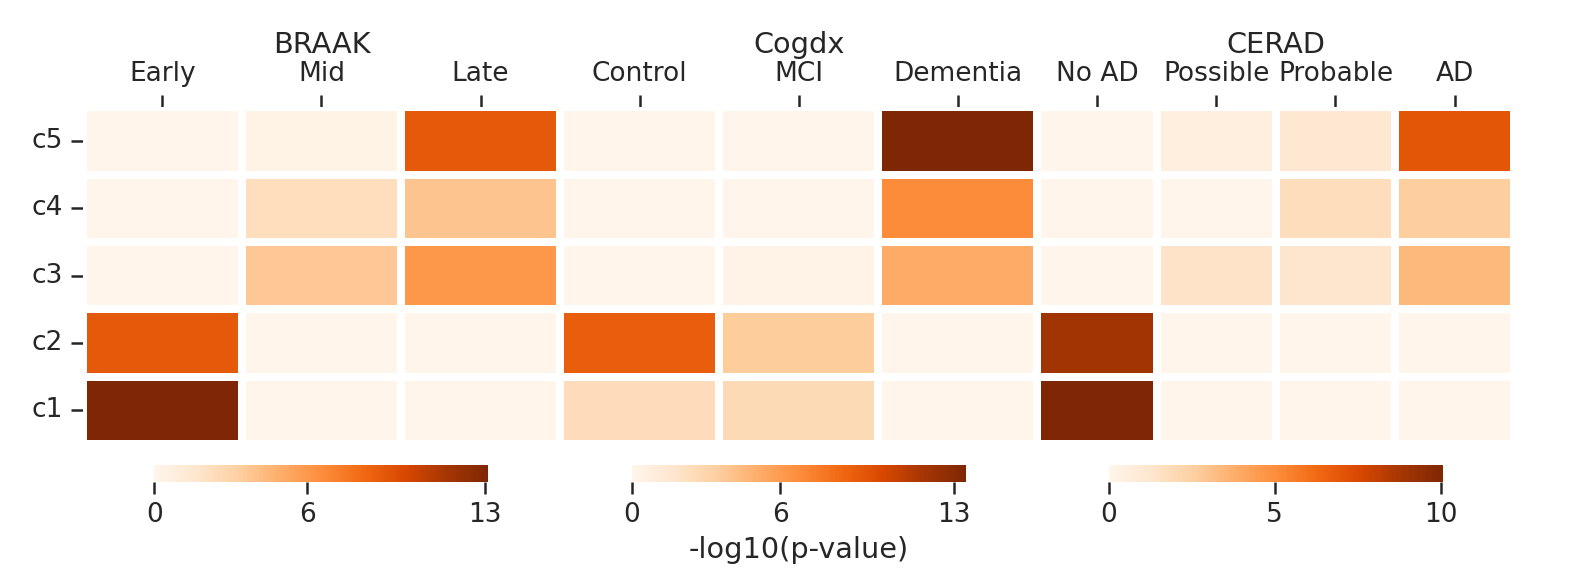

In [102]:
i=0
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(11,4), sharey=True,gridspec_kw = {'wspace':0, 'hspace':0})
fig.subplots_adjust(left=1.5, bottom=0.1, right=1.6)
sns.set(font_scale=1.2)

for ax,phen in zip([ax1, ax2, ax3],["BRAAK","Cogdx","CERAD"]):
    temp=enrich_df[enrich_df["c6"]==phen][["c1","c2","c3","c4","c5"]]
    temp=temp.T
    temp=temp[::-1]
    mid=int(0.5*(np.abs(np.min(temp))+np.int32(np.max(temp))))

    if i==1:
        clrbar_label="-log10(p-value)"
    else: 
        clrbar_label=""
        
    sns.heatmap(temp, cmap="Oranges", linewidths=4, xticklabels=True, yticklabels=True, ax=ax, 
                vmin=np.abs(np.min(temp)),vmax=np.abs(np.max(temp)),
                square=False, cbar_kws={"orientation": "horizontal", 
                                        "label": f"{clrbar_label}", "pad": 0.05,"shrink": 0.7})
    
    ax.set_xlabel(f"{phen}")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.xaxis.tick_top()  # x axis on top
    ax.xaxis.set_label_position('top')
    ax.yaxis.set_label_position('left')
    
    if i==0:
        ax.tick_params(axis='y', rotation=0)
        ax.yaxis.tick_left()
    i+=1
    
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([np.abs(np.min(temp)), mid,np.int32(np.max(temp))])
    
plt.tight_layout()
#plt.savefig("fig2d_enrichment_plot.png", dpi=300)
plt.show()